# One-Zone Model Degeneracies

Looking for degeneracies between Ia DTD and other parameters in the one-zone model outputs.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import vice
from vice.yields.presets import JW20

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

In [2]:
# Import data
data_dir = '/mnt/c/Users/dubay.11/OneDrive - The Ohio State University/Documents/Docs/First Year Project/Data'
# data_dir = 'C:\\Users\\dubay.11\\OneDrive - The Ohio State University\\Documents\\Docs\\First Year Project\\Data'
# data_dir = '~/Documents/Data'
data = pd.read_csv(Path(data_dir) / 'dr17_cut_data.csv')
data

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,APOKASC2_NOTE,APOK2_MASS,APOK2_MASS_ERR,APOK2_RADIUS,APOK2_RADIUS_ERR
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
1,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
2,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
3,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
4,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408656,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408657,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408658,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408659,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN


In [3]:
# Fiducial one-zone model: power-law DTD
sz = vice.singlezone(name='sz_fid', elements=('fe', 'o'))
print(sz)

vice.singlezone{
    name -----------> sz_fid
    func -----------> <function _DEFAULT_FUNC_ at 0x7f73eee9aaf0>
    mode -----------> ifr
    verbose --------> False
    elements -------> ('fe', 'o')
    IMF ------------> kroupa
    eta ------------> 2.5
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay ----------> 0.15
    RIa ------------> plaw
    Mg0 ------------> 6000000000.0
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    tau_star -------> 2.0
    schmidt --------> False
    schmidt_index --> 0.5
    MgSchmidt ------> 6000000000.0
    dt -------------> 0.01
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.014
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
}


In [4]:
simtime = np.linspace(0, 13.2, 1321) # Gyr
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_fid.vice
Overwite? (y | n)  n


In [49]:
# Power-law DTD with shorter 40 Myr delay time
sz = vice.singlezone(name='sz_short', elements=('o', 'fe'), RIa='plaw', delay=0.04)
sz.run(simtime)

In [73]:
# Exponential DTDs
# Medium timescale
sz = vice.singlezone(name='sz_exp', elements=('o', 'fe'), RIa='exp', tau_ia=1.5)
sz.run(simtime)
# Short timescale
sz = vice.singlezone(name='sz_sexp', elements=('o', 'fe'), RIa='exp', tau_ia=0.5)
sz.run(simtime)
# Long timescale
sz = vice.singlezone(name='sz_lexp', elements=('o', 'fe'), RIa='exp', tau_ia=5.5)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_exp.vice
Overwite? (y | n)  y


In [8]:
# Wide gaussian DTD
def gauss(t, sigma=1, center=1):
    return np.exp(-(t-center)**2/(2*sigma**2))

sz = vice.singlezone(name='sz_wgauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=2, center=3))
sz.run(simtime)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: RIa
  warnings.warn("""\


In [38]:
# Narrow gaussian DTD
sz = vice.singlezone(name='sz_ngauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=0.2, center=1))
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_ngauss.vice
Overwite? (y | n)  y


In [42]:
# Bimodal DTD
def bimodal(t, tau_ia=0.09):
    if t < tau_ia:
        return 10**(1.4 - 50*(np.log10(t*1e9) - 7.7)**2)
    else:
        return 10**(-0.8 - 0.9*(np.log10(t*1e9) - 8.7)**2)
    
sz = vice.singlezone(name='sz_bi', elements=('o', 'fe'), RIa=bimodal, delay=0.04)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_bi.vice
Overwite? (y | n)  y


In [36]:
# Uniform DTD
def uniform(t, tmin=0, tmax=1):
    if t >= tmin and t < tmax:
        return 1
    else:
        return 0

sz = vice.singlezone(name='sz_uni', elements=('o', 'fe'), RIa=uniform)
sz.run(simtime)

Plot Fe vs time, alpha vs time, and alpha vs Fe.

In [78]:
def tri_plot(tlim=(-1, 14), felim=(-2, 0.5), olim=(-0.3, 0.5)):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # First panel: metallicity vs time
    ax = axs[0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Second panel: alpha vs time
    ax = axs[1]
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[O/Fe]')

    # Third panel: alpha vs fe
    ax = axs[2]
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    
    return fig, axs

In [70]:
sz = vice.singlezone(name='sz_long_sfe', elements=('o', 'fe'), tau_star=5)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_long_sfe.vice
Overwite? (y | n)  y


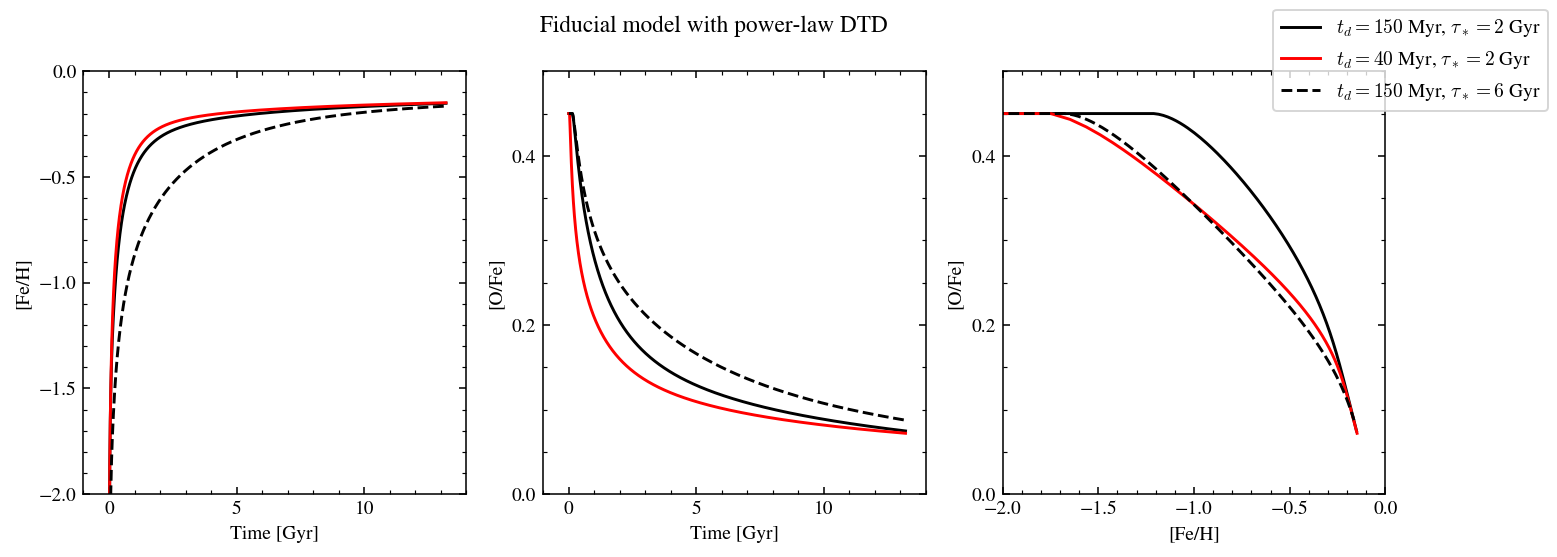

In [93]:
# Altering minimum delay time vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-2, 0), olim=(0, 0.5))
                                         
# 150 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=2$ Gyr'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 40 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.04, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=40$ Myr, $\tau_*=2$ Gyr'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 150 Myr delay with 5 Gyr SFE timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=6)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=6$ Gyr'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with power-law DTD')
fig.legend()
plt.show()

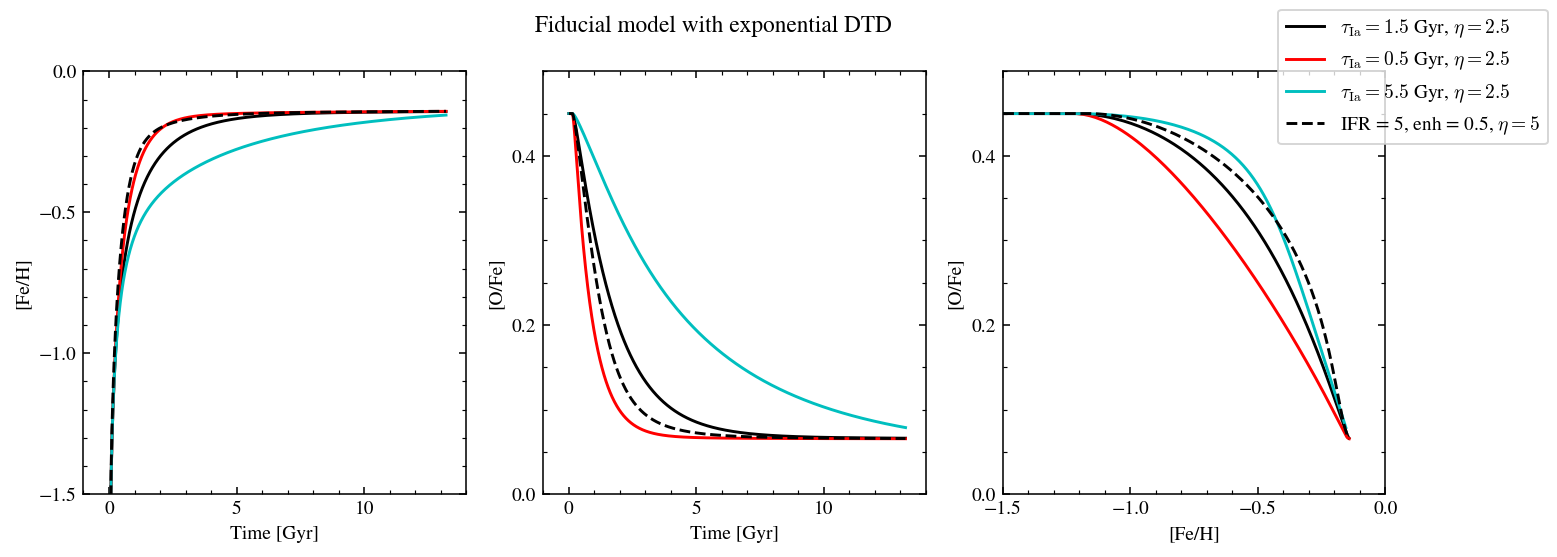

In [146]:
# Altering exponential Ia timescale vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-1.5, 0), olim=(0, 0.5))
                                         
# Fiducial Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=1.5$ Gyr, $\eta=2.5$'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Shorter Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=0.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=0.5$ Gyr, $\eta=2.5$'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Longer Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=5.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=5.5$ Gyr, $\eta=2.5$'
style = 'c'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Other parameter changes
# need to set Mg0
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, mode='ifr', func=lambda t: 5, enhancement=0.5, eta=5)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = 'IFR = 5, enh = 0.5, $\eta=5$'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with exponential DTD')
fig.legend()
plt.show()